# PCoA Jaccard index 

workflow:

1. Obtain reactions and metabolites for Human1 and Mitocore
Reaction origin need to be identified 
Metabolites do not need identification

2. Standarize metabolites ploted (ignore compartment: e.g. MAM01371c, MAM01334c) to fill binary matrix

3. Set the binary matrix and fill up
    reactions --> columns
    metabolites --> rows

4. Check repeated

4. Apply PCoA using Jaccart index  (represents similarity and diversity of samples)
5. Display and format PCA


In [63]:
import cobra
import re
from urllib import request 
from pprint import pprint
import pandas as pd
import cobra.flux_analysis
import numpy as np
import copy
import os 
import sklearn 

In [64]:
# read models
Human1 = cobra.io.read_sbml_model("/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/Human-GEM.xml")
mitocore= cobra.io.read_sbml_model("/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/Cleaned_Mitocore_changed_metabolites_metanetx.chemical.xml")

# 1. Obtain reactions and metabolites for Human1 and Mitocore

In [65]:
# extract reactions and metabolites from models
def extract_human1_in_mito(model, component):

    Hum1_in_Mitocore = []
    Hum1=[]

    # Iterate over the specified component (e.g., reactions or metabolites)
    for comp in getattr(model, component):

        #extract human1 ids from mitocore (from annotations)
        if model == mitocore:
            Human1_id = comp.annotation.get('Human1', None)
            if Human1_id is not None and component == 'reactions':
                #mark reactions with human1 ids comming from Mitocore model
                Hum1_in_Mitocore.append(Human1_id + '_mito')
            #do not mark metabolites with human1 ids comming from Mitocore model
            elif Human1_id is not None and component != 'reactions':
                Hum1_in_Mitocore.append(Human1_id) 

        #extract human1 ids from human1 model (model id)
        elif model == Human1:
            Human1_id = comp.id
            if Human1_id is not None:
                Hum1.append(Human1_id)

    return Hum1_in_Mitocore if model == mitocore else Hum1

Extract metabolites and reactions of Mitocore

In [66]:
mito_reactions_in_human1= extract_human1_in_mito(mitocore,'reactions')
print(len(mito_reactions_in_human1))
#proof if there are duplicates
mito_1=set(mito_reactions_in_human1)
print(len(mito_1))

mito_mets_in_human1= extract_human1_in_mito(mitocore,'metabolites')
print(len(mito_mets_in_human1))
#proof if there are duplicates
mito_1=set(mito_mets_in_human1)
print(len(mito_1))

395
346
421
261


Extract metabolites and reactions of Human1

In [67]:
reactions_in_human1= extract_human1_in_mito(Human1,'reactions')
print(len(reactions_in_human1))
#proof if there are duplicates
mito_1=set(reactions_in_human1)
print(mito_1)

mets_in_human1= extract_human1_in_mito(Human1,'metabolites')
print(len(mets_in_human1))
#proof if there are duplicates
mito_1=set(mets_in_human1)
print(len(mito_1))

12971
{'MAR07637', 'MAR07074', 'MAR06145', 'MAR02933', 'MAR09780', 'MAR05428', 'MAR10649', 'MAR00545', 'MAR09937', 'MAR08587', 'MAR08705', 'MAR04387', 'MAR01745', 'MAR01899', 'MAR07282', 'MAR06126', 'MAR02329', 'MAR12023', 'MAR13033', 'MAR09908', 'MAR09752', 'MAR03678', 'MAR05314', 'MAR01577', 'MAR01647', 'MAR00577', 'MAR11611', 'MAR12875', 'MAR12224', 'MAR05657', 'MAR07869', 'MAR04465', 'MAR09155', 'MAR07699', 'MAR12225', 'MAR10305', 'MAR03248', 'MAR03131', 'MAR02484', 'MAR02855', 'MAR10909', 'MAR09551', 'MAR01960', 'MAR09616', 'MAR03293', 'MAR08849', 'MAR10053', 'MAR07632', 'MAR08601', 'MAR04383', 'MAR07210', 'MAR05759', 'MAR02893', 'MAR09982', 'MAR02912', 'MAR09296', 'MAR01380', 'MAR05005', 'MAR08279', 'MAR10763', 'MAR10172', 'MAR04317', 'MAR00950', 'MAR06450', 'MAR06091', 'MAR04946', 'MAR11752', 'MAR01259', 'MAR09562', 'MAR09536', 'MAR12721', 'MAR03321', 'MAR00533', 'MAR07504', 'MAR07815', 'MAR10917', 'MAR10434', 'MAR04374', 'MAR12564', 'MAR11899', 'MAR12267', 'MAR08638', 'MAR11634

# 2. Standarize metabolites plotted to fill binary matrix
(ignore compartment: e.g. MAM01371c, MAM01334c)

1. Open organizers to collect reactions, metabolites and a tuple that contains both to fill up binary matrix
2. Extract reactions and metabolites from Mitocore (if Human1 id available), randomize metabolites and reactions with same Human1 identifier.
3. Extract reactions and metabolites ids from Human1 
4. Build binary matrix and fill it
6. Save binary matrix into csv


In [68]:
import pandas as pd
from sklearn.metrics import pairwise_distances
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa

# Pattern to match Human1 metabolite ids with compartment assignment (e.g., MAM01234, MAM01234c, MAM01234m)
pattern_met_human1 = re.compile(r'^(MAM0\d{4})[a-zA-Z]?$')


# 1. Collect all reactions (mapped to Human1 ids)
all_reactions = []
# collect all metabolites (normalized to base id without compartment) and remove duplicates
all_metabolites = set()
# metabolites which are in each reaction
reaction_metabolite_map = {}

# 2. From Mitocore (mapped to Human1 ids if available)
for react in mitocore.reactions:
    human1_id = react.annotation.get('Human1', None)
    # if reaction in mitocore has Human1 id, otherwise skip
    if human1_id is not None:  # only take mapped reactions
        base_react= human1_id
        # add identifier for Mitocore model '_mit'
        classif_id=base_react + '_mit'
        all_reactions.append(classif_id)
        #store the reaction with human1 id into a mapping dictionary
        reaction_metabolite_map[classif_id] = []
        
        for met in react.metabolites:
            met_human1_id = met.annotation.get('Human1', None)
            # if  metabolite in mitocore has Human1 id, otherwise skip
            if met_human1_id is not None:
                match = pattern_met_human1.match(met_human1_id)
                # Check if the pattern matched
                if match: 
                    base_met = match.group(1)
                    all_metabolites.add(base_met)
                    #store the metabolites in the reaction into the mapping dictionary
                    reaction_metabolite_map[classif_id].append(base_met)

# 3. From Human1 (direct ids)
for react in Human1.reactions:
    human1_id = react.id
    base_react= human1_id
    # add identifier for Human1 model '_hum'
    classif_id= base_react + '_hum'
    all_reactions.append(classif_id)
    reaction_metabolite_map[classif_id] = []

    for met in react.metabolites:
        met_human1_id = met.id
        # check if human1 id is in the mapping dataframe
        match = pattern_met_human1.match(met_human1_id)
        if match:  # Ensure match is not None
            base_met = match.group(1)
            all_metabolites.add(base_met)
            reaction_metabolite_map[classif_id].append(base_met)


print (len(all_reactions))
# there are duplicates in Human1 ids for the mitocore reactions because mitocore has the same reaction specified in different compartments with different reaction.id
all_reactions= set(all_reactions)
print(len(all_reactions))

# 4. Build binary matrix and fill it up
binary_matrix = pd.DataFrame(0, index=sorted(all_metabolites), columns=sorted(all_reactions))

# Fill the binary matrix based on finding normalized metabolite ids in reactions in the binary matrix
for rxn, mets in reaction_metabolite_map.items():
    for base_met in mets:  # already normalized metabolite 
        if base_met in binary_matrix.index:
            binary_matrix.loc[base_met, rxn] = 1

# 6. Save for checking
binary_matrix.to_csv('binary_matrix.csv')

print("Binary matrix shape:", binary_matrix.shape)
print(binary_matrix.head())



13366
13317
Binary matrix shape: (4040, 13317)
          MAR00001_hum  MAR00002_hum  MAR00003_hum  MAR00004_hum  \
MAM00001             0             0             0             0   
MAM00002             0             0             0             0   
MAM00003             0             0             0             0   
MAM00004             0             0             0             0   
MAM00005             0             0             0             0   

          MAR00005_hum  MAR00006_hum  MAR00007_hum  MAR00008_hum  \
MAM00001             0             0             0             0   
MAM00002             0             0             0             0   
MAM00003             0             0             0             0   
MAM00004             0             0             0             0   
MAM00005             0             0             0             0   

          MAR00009_hum  MAR00010_hum  ...  MAR20174_hum  MAR20175_hum  \
MAM00001             0             0  ...             0       

# 3. Check if duplicates in Mitocore (same Human1 id) are errors 
There are reactions in mitocore with the same Human1 id, it had to be checked if the same identifier is caused by unespecificity of the Human1 reactions or by errors during curation


1. Extract duplicates in mitocore with same Human1 id to check if they can be removed or error when adding Human1 ids   
2. Test manually if these duplicates plot the same reaction but with small difference (e.g. compartment specific reactions) or indeed are errors during curation

Note: as exprected duplicates represent just higher specificity of certain reactions in Mitocore compared to Human1 (e.g. transport reactions, ocurring in differet comparments have the same Human1 identifier but different id in Mitocore) so the reactions can be just assumed as one for comparisson.

In [69]:

# 1. Extract duplicates in mitocore with same Human1 id
# Collect all reactions (mapped to Human1 ids)
all_reactions = {}

# iterate over reactions
for react in mitocore.reactions:
    human1_id = react.annotation.get('Human1', None)
    mito_id= react.id
    # if reaction in mitocore has Human1 id, otherwise skip
    if human1_id is not None:  # only take mapped reactions
        if human1_id not in all_reactions:
            all_reactions[human1_id] = []
        all_reactions[human1_id].append(mito_id)

# extract duplicates in mitocore with same Human1 id to check if they can be removed or error when adding Human1 ids        
duplicates = {hum: mit for hum, mit in all_reactions.items() if len(mit) > 1}

print(f"Found {len(duplicates)} duplicate Human1 mappings")
for hum, mit in duplicates.items():
    print(f"Human1 reaction {hum} maps to Mitocore reactions: {mit}")

Found 49 duplicate Human1 mappings
Human1 reaction MAR04101 maps to Mitocore reactions: ['PEPCK', 'PEPCKm']
Human1 reaction MAR04408 maps to Mitocore reactions: ['FUMm', 'FUM']
Human1 reaction MAR04139 maps to Mitocore reactions: ['MDHm', 'MDH']
Human1 reaction MAR04089 maps to Mitocore reactions: ['ME2m', 'ME2']
Human1 reaction MAR03899 maps to Mitocore reactions: ['r0081', 'ALATA_L']
Human1 reaction MAR04149 maps to Mitocore reactions: ['ACITLm_MitoCore', 'ACITL']
Human1 reaction MAR04016 maps to Mitocore reactions: ['NDPK1m', 'NDPK1']
Human1 reaction MAR04002 maps to Mitocore reactions: ['ADK1m', 'ADK1']
Human1 reaction MAR03827 maps to Mitocore reactions: ['ASPTA', 'ASPTAm']
Human1 reaction MAR02599 maps to Mitocore reactions: ['C160CPT1', 'C160CPT2']
Human1 reaction MAR03975 maps to Mitocore reactions: ['PPA', 'PPAm']
Human1 reaction MAR03912 maps to Mitocore reactions: ['CYSTA', 'CYSTAm']
Human1 reaction MAR06518 maps to Mitocore reactions: ['MCPST', 'MCPSTm_MitoCore']
Human1 rea

In [70]:
# 2. Test manually if these duplicates plot the same reaction
react= mitocore.reactions.get_by_id('r0514')

print(react.metabolites)
react_human1= react.annotation.get('Human1', None)
#exrtract reaction with mitocore ids
print(react)
print('react Human1:',react_human1)

#extract metabolites in mitocore id and Human1 id 
mets= react.metabolites
for met in mets:
    met_id= met.id
    print('met mito:', met_id)
    met_Human1= met.annotation.get('Human1', None)
    print('met hum in mito:', met_Human1)

#exrtract reaction with Human1 ids
react_h= Human1.reactions.get_by_id('MAR04655')
print('human1:', react_h)


{<Metabolite nadph_m at 0x2aee73250>: -1.0, <Metabolite fol_m at 0x2aef077d0>: -1.0, <Metabolite nadp_m at 0x2aee71510>: 1.0, <Metabolite dhf_m at 0x2aef87410>: 1.0}
r0514: fol_m + nadph_m <=> dhf_m + nadp_m
react Human1: MAR04655
met mito: nadph_m
met hum in mito: MAM02555c
met mito: fol_m
met hum in mito: MAM01830c
met mito: nadp_m
met hum in mito: MAM02554c
met mito: dhf_m
met hum in mito: MAM01700c
human1: MAR04655: MAM01830c + MAM02555c <=> MAM01700c + MAM02554c


# 4. Run PCoA based on distance-matrix calculated with Jaccard distance

In [71]:
# Load binary matrix
binary_matrix = pd.read_csv('binary_matrix.csv', index_col=0)
# Compute Jaccard distance between reactions (transpose so models/reactions are rows)
dist_array = pairwise_distances(binary_matrix.T.values, metric="jaccard")
# DistanceMatrix
dist_matrix = DistanceMatrix(dist_array, ids=binary_matrix.columns.tolist())
# Run PCoA 
pcoa_results = pcoa(dist_matrix) 
print(pcoa_results.samples.head())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


                   PC1       PC2       PC3       PC4       PC5       PC6  \
MAR00001_hum -0.145656  0.008610 -0.007221 -0.021969 -0.014009 -0.050870   
MAR00002_hum  0.028340 -0.261160 -0.115779  0.051471 -0.047166 -0.027353   
MAR00003_hum  0.028522 -0.261341 -0.115843  0.051588 -0.047149 -0.027139   
MAR00004_hum -0.145193  0.008233 -0.007342 -0.021696 -0.013946 -0.050313   
MAR00005_hum  0.029787 -0.261955 -0.116141  0.051927 -0.048107 -0.027577   

                   PC7       PC8       PC9      PC10  ...  PC13308  PC13309  \
MAR00001_hum -0.009850 -0.001049 -0.022571 -0.010969  ...      0.0      0.0   
MAR00002_hum  0.032779 -0.022708 -0.009419 -0.012135  ...      0.0      0.0   
MAR00003_hum  0.032859 -0.022740 -0.009248 -0.012052  ...      0.0      0.0   
MAR00004_hum -0.009664 -0.001109 -0.022130 -0.010748  ...      0.0      0.0   
MAR00005_hum  0.034778 -0.023574 -0.009237 -0.012312  ...      0.0      0.0   

              PC13310  PC13311  PC13312  PC13313  PC13314  PC13315  

# 5. Vizualization of the PCoA

1. PCoA without classifiers (Mito, Human1)
2. PCoA with classifiers (Mito, Human1)

/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_35122/936091997.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_35122/936091997.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')


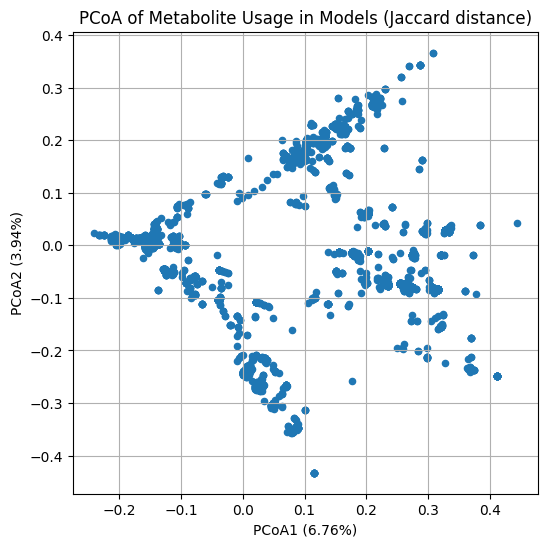

In [72]:
# 1. PCA plot  option 1 (no classifier)

import matplotlib.pyplot as plt  

coords = pcoa_results.samples

plt.figure(figsize=(6,6))
plt.scatter(coords.iloc[:,0], coords.iloc[:,1], s=20)

plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')
plt.title('PCoA of Metabolite Usage in Models (Jaccard distance)')
plt.grid(True)
plt.show()

/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_35122/3695658415.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_35122/3695658415.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')


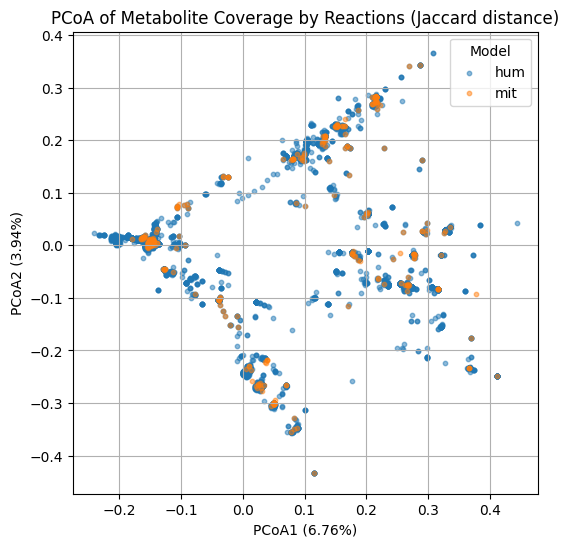

In [73]:
# 2. PCA cluster option 2 (classifier)

# to keep original PCoA results intact as an object
coords = pcoa_results.samples.copy()

# Extract classifier labels from reaction IDs (suffix "_mit" or "_hum")
coords["label"] = coords.index.str.split("_").str[-1]  

# Plot
plt.figure(figsize=(6,6))
for label, subset in coords.groupby("label"):
    plt.scatter(
        subset.iloc[:, 0], 
        subset.iloc[:, 1], 
        s=10, 
        label=label,
        alpha= 0.5
    )

plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')
plt.title('PCoA of Metabolite Coverage by Reactions (Jaccard distance)')
plt.legend(title="Model")
plt.grid(True)
plt.show()

https://rest.kegg.jp/get/M00549

# -------------------------------CHECK POINT-------------------------------------------
# ---------------------------PCoA with KEGG module assignment-----------------

In [74]:
def sort_kegg_ids (model,target_db):
    """Extract reaction id for a target database from a defined model, if >1 id 
    add all ids as new entries.

    model: COBRApy model (loaded model)
    target_db: database key in the annotations of the model
    """
    import re
    pattern=r'R\d{5}' #Pattern KEGG ids recognition (e.g. R00209)

    kegg_react={'model_id':[], target_db:[]}

    #get reaction annotations from an object (loaded model)
    reactions= getattr(model , 'reactions')
    for reaction in reactions:
        target_id=reaction.annotation.get(target_db)

         # Normalize annotation value to string
        if isinstance(target_id, list):
            target_id = ' '.join(target_id)
        else:
            target_id = str(target_id)

        # Find all KEGG ids (e.g. R00209, R01324, etc.)
        matches = re.findall(pattern, target_id) #re.findall() works just with str
        for match in matches:
            kegg_react['model_id'].append(reaction.id)
            kegg_react[target_db].append(match)

    return pd.DataFrame.from_dict(kegg_react)

# PCoA with KEGG-module categorisation

1. create dictionary with KEGG module and KEGG id reactions
2. translate KEGG modules from KEGG ids in form M00549': ['R01786, R02189, R00959, R00289'] to Human1 ids 
3. Create mapping dataframe with headers ['KEGG module', 'Human1 id', 'module name']
4. collect reactions and metabolite, add identifier for reactions by [model, KEGG module]
5. run PCoA and save as csv file
6. create double clasifier ['model', 'kegg module name'] into new columns in PCoA dataframe
7. plot PCoA with KEGG module label 

# 1. Create dictionary with KEGG module and KEGG id reactions

In [75]:
# 1. Create dictionary with strcture
#  {'M00549': ['R01786, R02189'], 'M00002': ['R01015, R07159']}
#read csv file with kegg modules, reactions, metabolites, genes.
module_reactions = pd.read_csv('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/KEGG_Modules/modules_content.csv') 
import re
pattern = r'R\d{5}'  # Pattern KEGG ids recognition (e.g. R00209)
modules_kegg_dict = {}

#sort out into dictionary with {'module': [kegg id reactions]}
for index, row in module_reactions.iterrows():
    module = row['module_id']
    reactions = row['reactions']
    matches = re.findall(pattern, reactions)  # re.findall() works just with str
    if matches:
        if module not in modules_kegg_dict:
            modules_kegg_dict[module] = []  # Initialize the list for the module
        modules_kegg_dict[module].append(', '.join(matches))  # Join matches into a single string
print(modules_kegg_dict)
 
# map reactions from kegg to human1 in dictionary
#{'module': [kegg id reactions]} --> {'module': [human1 id reactions]}



{'M00001': ['R01786, R02189, R09085, R13199, R00756, R05805, R01068, R01015, R01061, R01063, R01512, R07159, R01518, R00658, R00200'], 'M00549': ['R01786, R02189, R00959, R00289'], 'M00002': ['R01015, R01061, R01063, R01512, R07159, R01518, R00658, R00200'], 'M00003': ['R00431, R00726, R00341, R00658, R01518, R01512, R01061, R01063, R01015, R01068, R00762'], 'M00165': ['R01523, R00024, R01512, R01061, R01063, R01015, R01068, R00762, R01067, R01829, R01845, R01641, R01056, R01529'], 'M00308': ['R01538, R01541, R05605, R01061, R01512, R01058, R10860'], 'M00552': ['R03033, R03387, R01064, R01061, R01512'], 'M00346': ['R00945, R00588, R01388, R08572, R00658, R00345, R00342, R01256, R00473, R00588'], 'M00004': ['R02736, R10907, R02035, R01528, R10221, R01529, R01056, R01641, R08575, R01067, R13199, R02739'], 'M00006': ['R02736, R10907, R02035, R01528, R10221'], 'M00008': ['R02736, R02035, R02036, R05605'], 'M00007': ['R01067, R08575, R01641, R01529, R01056'], 'M00580': ['R05339, R05338, R01

# 2. Translate KEGG modules from KEGG ids in form M00549': ['R01786, R02189, R00959, R00289'] to Human1 ids 

In [76]:
# 2. translate KEGG modules from KEGG ids to Human1 ids

#read human1 model 
human1= cobra.io.read_sbml_model('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/Human-GEM.xml')
#extract kegg ids
human1_kegg= sort_kegg_ids(human1,'kegg.reaction')
#print(human1_kegg)

# convert dictionary with kegg ids to human1 ids
modules_human1_dict = {}

for key, reactions in modules_kegg_dict.items():
    for reaction in reactions:
        # split the reaction string into individual kegg ids
        reaction_ids = reaction.split(', ')
        
        for reaction_id in reaction_ids:
            # filter dataframe for matches
            matches = human1_kegg[human1_kegg['kegg.reaction'] == reaction_id]
            
            if not matches.empty:
                # initialize list if key not in dict yet
                if key not in modules_human1_dict:
                    modules_human1_dict[key] = []
                
                # add all matching model_ids (could be more than one)
                modules_human1_dict[key].extend(matches['model_id'].dropna().tolist())

print(modules_human1_dict)


    

{'M00001': ['MAR04379', 'MAR04375', 'MAR04391', 'MAR04373', 'MAR04368', 'MAR04365', 'MAR04363', 'MAR04358'], 'M00549': ['MAR03944'], 'M00002': ['MAR04391', 'MAR04373', 'MAR04368', 'MAR04365', 'MAR04363', 'MAR04358'], 'M00003': ['MAR04101', 'MAR04103', 'MAR04363', 'MAR04365', 'MAR04368', 'MAR04373', 'MAR04391', 'MAR04375', 'MAR04377'], 'M00165': ['MAR04368', 'MAR04373', 'MAR04391', 'MAR04375', 'MAR04377', 'MAR04404', 'MAR04355', 'MAR04501', 'MAR04351', 'MAR04352', 'MAR04477'], 'M00308': ['MAR04373', 'MAR04368'], 'M00552': ['MAR04373', 'MAR04368'], 'M00346': ['MAR03845', 'MAR04792', 'MAR08782', 'MAR08781', 'MAR04363', 'MAR04139', 'MAR04141'], 'M00004': ['MAR04623', 'MAR04625', 'MAR04473', 'MAR04474', 'MAR04477', 'MAR04351', 'MAR04352', 'MAR04501', 'MAR04565', 'MAR04404', 'MAR04856'], 'M00006': ['MAR04623', 'MAR04625', 'MAR04473', 'MAR04474'], 'M00008': ['MAR04623', 'MAR04625'], 'M00007': ['MAR04404', 'MAR04565', 'MAR04501', 'MAR04477', 'MAR04351', 'MAR04352'], 'M00580': ['MAR04351', 'MAR

# 3. Create mapping dataframe with headers ['KEGG module', 'Human1 id', 'module name']


In [77]:
# 3. Create mapping dataframe with headers ['KEGG module', 'Human1 id', 'module name']
# open dict to catch each reaction with respective module
# form {'human1 id reaction':['KEGG module']}
reactions_map = {}

for key, values in modules_human1_dict.items():
    for value in values:
        reactions_map[value] = [key]  # Wrap the value in a list to ensure correct DataFrame shape

# Create DataFrame with correct shape
reactions_map_df = pd.DataFrame(list(reactions_map.items()), columns=['Human1','KEGG_module'])
print(reactions_map_df)

# convert list in 'KEGG_module' column to string
reactions_map_df['KEGG_module'] = reactions_map_df['KEGG_module'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x
)

modules_names= pd.read_csv('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/KEGG_Modules/Modules_Human1_vs_Mitocore.csv')

for index, row in reactions_map_df.iterrows():
    module = row['KEGG_module']
    if module in modules_names['module'].values:
        matched_row = modules_names.loc[modules_names['module'] == module, 'module name']
        if not matched_row.empty:
            module_name = matched_row.values[0]
            reactions_map_df.at[index, 'module name'] = module_name

print(reactions_map_df)

       Human1 KEGG_module
0    MAR04379    [M00345]
1    MAR04375    [M00344]
2    MAR04391    [M00165]
3    MAR04373    [M00552]
4    MAR04368    [M00552]
..        ...         ...
705  MAR02115    [M00103]
706  MAR02117    [M00103]
707  MAR02118    [M00103]
708  MAR08008    [M00103]
709  MAR20039    [M00538]

[710 rows x 2 columns]
       Human1 KEGG_module                                        module name
0    MAR04379      M00345  Formaldehyde assimilation, ribulose monophosph...
1    MAR04375      M00344  Formaldehyde assimilation, xylulose monophosph...
2    MAR04391      M00165   Reductive pentose phosphate cycle (Calvin cycle)
3    MAR04373      M00552  D-galactonate degradation, De Ley-Doudoroff pa...
4    MAR04368      M00552  D-galactonate degradation, De Ley-Doudoroff pa...
..        ...         ...                                                ...
705  MAR02115      M00103                       Cholecalciferol biosynthesis
706  MAR02117      M00103                       

 ## 4. Collect reactions and metabolite, add identifier for reactions by [model, KEGG module]
    4.1 Collecting dictionaries
    4.2 Extract Human1 ids for reactions from mitocore 
        4.2.1 extract Human1 ids for metabolties from mitocore 
    4.3. Direct extraction Human1 ids for reactions from Human1
        4.3.1 extract Human1 ids for metabolties from mitocore 
    4.4. Build binary matrix and fill it up
    4.5 Save Matrix as csv file



In [78]:
# 4. collect reactions and metabolite, characterize reactions by model and KEGG module
import pandas as pd
from sklearn.metrics import pairwise_distances
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
import re 

# Pattern to match Human1 metabolite ids with compartment assignment (e.g., MAM01234, MAM01234c, MAM01234m)
pattern_met_human1 = re.compile(r'^(MAM0\d{4})[a-zA-Z]?$')

# 4.1. collecting dictionaries

# # all reactions (mapped to Human1 ids)
all_reactions = []
# collect all metabolites (normalized to base id without compartment) and remove duplicates
all_metabolites = set()
# metabolites which are in each reaction
reaction_metabolite_map = {}


# 4.2. extract Human1 ids for reactions from mitocore 
for react in mitocore.reactions:
    human1_id = react.annotation.get('Human1', None)
    # if reaction in mitocore has Human1 id, otherwise skip --> (just 375 reactions out of 555 have Human1 ids)
    if human1_id is not None:
        # check if human1 id is in the mapping dataframe
        match_row = reactions_map_df.loc[reactions_map_df['Human1'] == human1_id]
        if not match_row.empty:
            kegg_module = match_row['KEGG_module'].values[0]

            base_react = human1_id
            classif_id = kegg_module + '/' + base_react + '_mito'

            all_reactions.append(classif_id)
            # store the reaction with human1 id into a mapping dictionary 
            reaction_metabolite_map[classif_id] = []

            # 4.2.1 extract Human1 ids for metabolties from mitocore 
            # loop inside reaction loop to check just if reaction is available with Human1 ids (classif_id is defined)
            for met in react.metabolites:
                met_human1_id = met.annotation.get('Human1', None)
                # if metabolite in mitocore has Human1 id, otherwise skip
                if met_human1_id is not None:
                    match = pattern_met_human1.match(met_human1_id)
                    # Check if the pattern matched
                    if match:
                        base_met = match.group(1)
                        all_metabolites.add(base_met)
                        # store the metabolites in the reaction into the mapping dictionary
                        reaction_metabolite_map[classif_id].append(base_met)

# 4.3. extract Human1 ids for reactions from Human1
# direct extraction since Human1 ids are already in Human1 model
for react in Human1.reactions:
    human1_id = react.id
    if human1_id is not None:
        # check if human1 id is in the mapping dataframe
        match_row = reactions_map_df.loc[reactions_map_df['Human1'] == human1_id]
        if not match_row.empty:
            kegg_module = match_row['KEGG_module'].values[0]

            base_react = human1_id
            classif_id = kegg_module + '/' + base_react + '_hum'

            all_reactions.append(classif_id)
            reaction_metabolite_map[classif_id] = []

            # 4.3.1 extract Human1 ids for metabolties from mitocore 
            for met in react.metabolites:
                met_human1_id = met.id
                match = pattern_met_human1.match(met_human1_id)
                if match:  # Ensure match is not None
                    base_met = match.group(1)
                    all_metabolites.add(base_met)
                    reaction_metabolite_map[classif_id].append(base_met)

print(len(all_reactions))
# there are duplicates in Human1 ids for the mitocore reactions because mitocore has the same reaction specified in different compartments with different reaction.id
all_reactions = set(all_reactions)
print(len(all_reactions))

# 4.4. Build binary matrix and fill it up
binary_matrix = pd.DataFrame(0, index=sorted(all_metabolites), columns=sorted(all_reactions))
# Fill the binary matrix based on finding normalized metabolite ids in reactions in the binary matrix
for rxn, mets in reaction_metabolite_map.items():
    for base_met in mets:  # already normalized metabolite 
        if base_met in binary_matrix.index:
            binary_matrix.loc[base_met, rxn] = 1

# 4.5. Save for checking
binary_matrix.to_csv('binary_matrix_kegg_modules.csv')

print("Binary matrix shape:", binary_matrix.shape)
print(binary_matrix.head())

911
894
Binary matrix shape: (601, 894)
          M00002/MAR04358_hum  M00002/MAR04358_mito  M00003/MAR04101_hum  \
MAM00036                    0                     0                    0   
MAM00037                    0                     0                    0   
MAM00038                    0                     0                    0   
MAM00039                    0                     0                    0   
MAM00041                    0                     0                    0   

          M00003/MAR04101_mito  M00003/MAR04103_hum  M00003/MAR04365_hum  \
MAM00036                     0                    0                    0   
MAM00037                     0                    0                    0   
MAM00038                     0                    0                    0   
MAM00039                     0                    0                    0   
MAM00041                     0                    0                    0   

          M00003/MAR04365_mito  M00004/MAR0485

# 5. Run PCoA and save as csv file


In [79]:
# 5. run PCoA 
#  Load binary matrix
binary_matrix = pd.read_csv('binary_matrix_kegg_modules.csv', index_col=0)
# Compute Jaccard distance between reactions (transpose so models/reactions are rows)
dist_array = pairwise_distances(binary_matrix.T.values, metric="jaccard")
# DistanceMatrix
dist_matrix = DistanceMatrix(dist_array, ids=binary_matrix.columns.tolist())
# Run PCoA 
pcoa_results = pcoa(dist_matrix) 
print(pcoa_results.samples)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


                           PC1       PC2       PC3       PC4       PC5  \
M00002/MAR04358_hum   0.143823 -0.311933 -0.083279  0.274199  0.015898   
M00002/MAR04358_mito  0.143823 -0.311933 -0.083279  0.274199  0.015898   
M00003/MAR04101_hum  -0.050336 -0.093622  0.050746 -0.143469 -0.044176   
M00003/MAR04101_mito -0.050336 -0.093622  0.050746 -0.143469 -0.044176   
M00003/MAR04103_hum  -0.050336 -0.093622  0.050746 -0.143469 -0.044176   
...                        ...       ...       ...       ...       ...   
M01016/MAR08768_hum   0.323188  0.123737  0.300423  0.054901 -0.050147   
M01022/MAR08674_hum  -0.081999 -0.069002  0.054428 -0.113403 -0.066981   
M01027/MAR07696_hum   0.140306 -0.030539 -0.031981 -0.013872  0.096398   
M01027/MAR07697_hum  -0.299620  0.179744 -0.016401  0.056882 -0.013306   
M01036/MAR04159_hum  -0.075116 -0.069803  0.048713 -0.113713 -0.054594   

                           PC6       PC7       PC8       PC9      PC10  ...  \
M00002/MAR04358_hum  -0.005526 -

# 6. Create double clasifier ['model', 'kegg module name'] into new columns in PCoA dataframe


In [80]:
# 6.create clasifier for plot ['model', 'KEGG module name']
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Copy PCoA coordinates and keep labels
coords = pcoa_results.samples.copy()
print(type(coords))

# Extract model label ("_mitO" or "_hum") from the reaction id --> add as new column in PCoA dataframe
coords["Model"] = coords.index.str.split("_").str[-1]
# Extract KEGG module label (before the model suffix, separated by "/") --> add as new column in PCoA dataframe
coords["KEGG_Module"] = coords.index.str.split("/").str[0]   # first element is module
print(coords)
# extract the module name from dataframe

# iterate over rows to map KEGG module names
for index, row in coords.iterrows():
    kegg_module = row['KEGG_Module']
    matched_row = reactions_map_df.loc[reactions_map_df['KEGG_module'] == kegg_module]
    if not matched_row.empty:
        #add module name to new column in PCoA dataframe
        module_name = matched_row['module name'].values[0]
        coords.at[index, 'KEGG module name'] = module_name
print(coords)



<class 'pandas.core.frame.DataFrame'>
                           PC1       PC2       PC3       PC4       PC5  \
M00002/MAR04358_hum   0.143823 -0.311933 -0.083279  0.274199  0.015898   
M00002/MAR04358_mito  0.143823 -0.311933 -0.083279  0.274199  0.015898   
M00003/MAR04101_hum  -0.050336 -0.093622  0.050746 -0.143469 -0.044176   
M00003/MAR04101_mito -0.050336 -0.093622  0.050746 -0.143469 -0.044176   
M00003/MAR04103_hum  -0.050336 -0.093622  0.050746 -0.143469 -0.044176   
...                        ...       ...       ...       ...       ...   
M01016/MAR08768_hum   0.323188  0.123737  0.300423  0.054901 -0.050147   
M01022/MAR08674_hum  -0.081999 -0.069002  0.054428 -0.113403 -0.066981   
M01027/MAR07696_hum   0.140306 -0.030539 -0.031981 -0.013872  0.096398   
M01027/MAR07697_hum  -0.299620  0.179744 -0.016401  0.056882 -0.013306   
M01036/MAR04159_hum  -0.075116 -0.069803  0.048713 -0.113713 -0.054594   

                           PC6       PC7       PC8       PC9      PC10  .

# 7. Plot PCoA with KEGG module label 

/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_35122/1058252235.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_35122/1058252235.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')


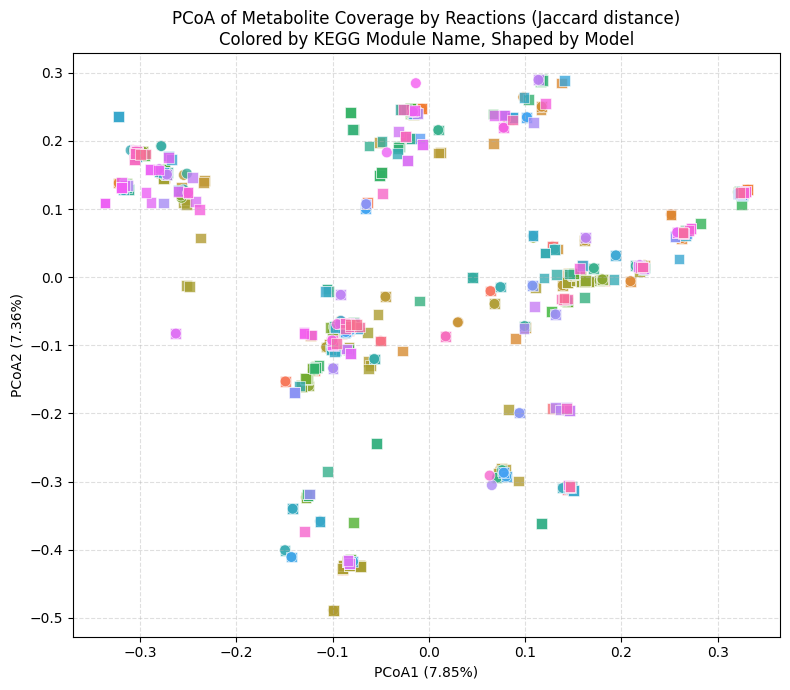

In [81]:
# 7. Plot with seaborn classifier
plt.figure(figsize=(8, 7))

scatter = sns.scatterplot(
    data=coords,
    x=coords.columns[0],
    y=coords.columns[1],
    hue="KEGG module name",
    style="Model",
    markers={"mito": "o", "hum": "s"},
    style_order=["mito", "hum"],
    s=60, alpha=0.8, linewidth=0.5,
    legend= False
)

plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')
plt.title('PCoA of Metabolite Coverage by Reactions (Jaccard distance)\n'
          'Colored by KEGG Module Name, Shaped by Model')

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_35122/3937781259.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_35122/3937781259.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')
/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_35122/3937781259.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tigh

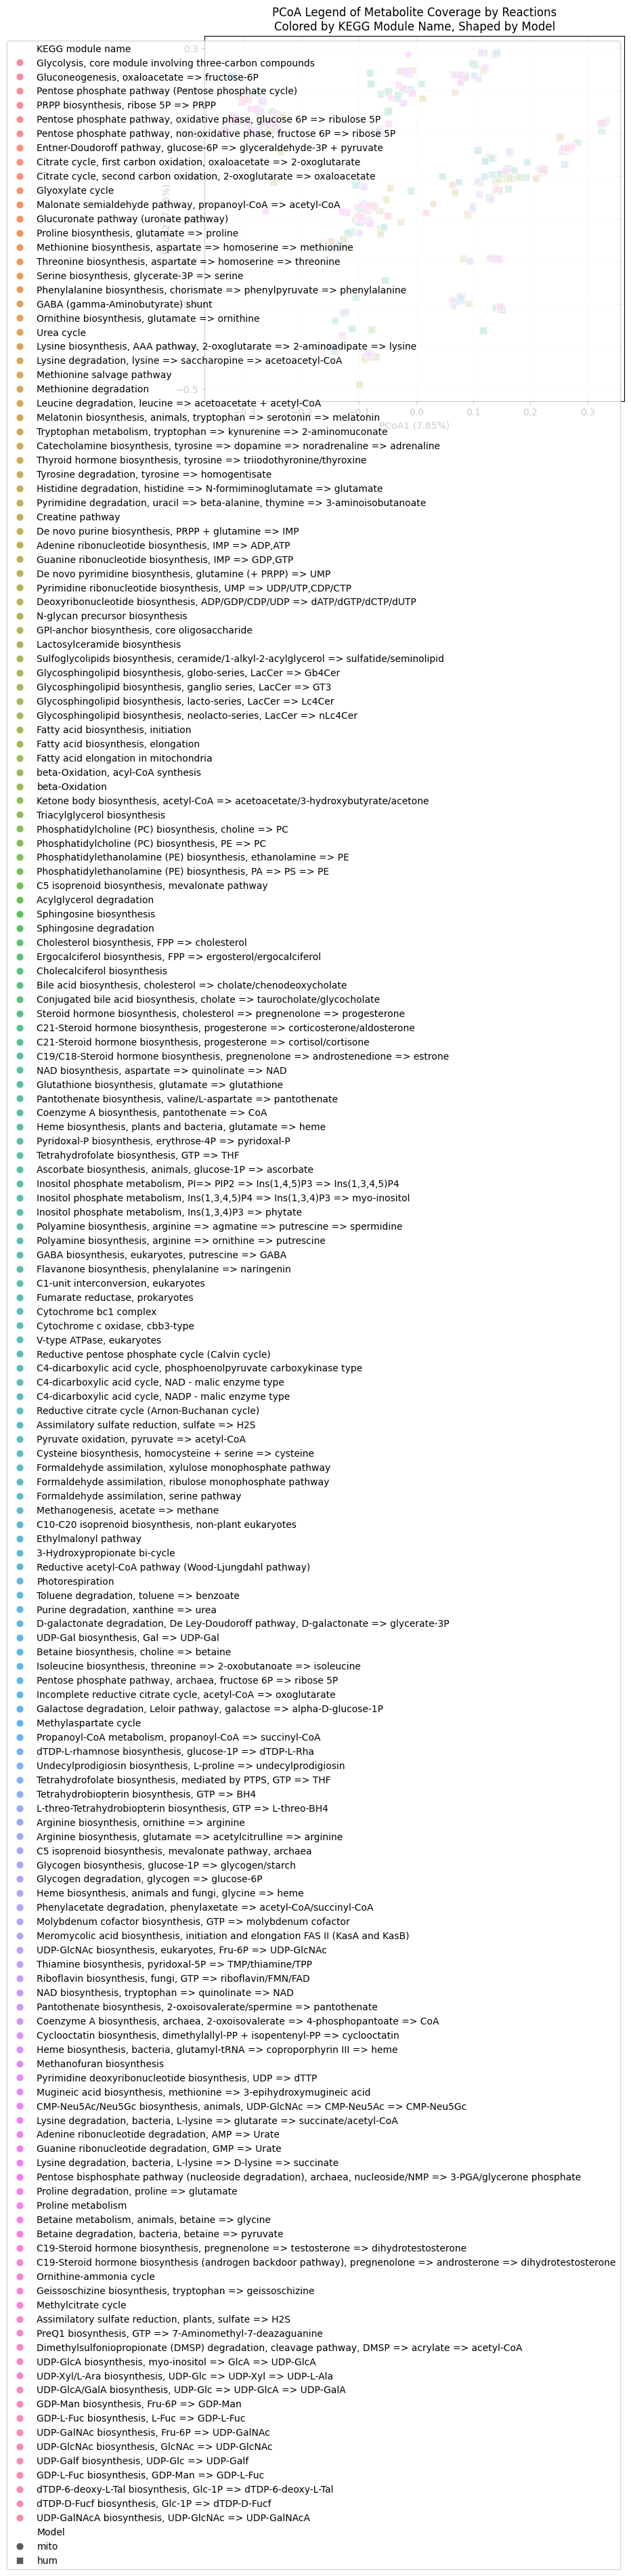

In [61]:
plt.figure(figsize=(8, 7))

scatter = sns.scatterplot(
    data=coords,
    x=coords.columns[0],
    y=coords.columns[1],
    hue="KEGG module name",
    style="Model",
    markers={"mito": "o", "hum": "s"},
    style_order=["mito", "hum"],
    s=60, alpha=0.8, linewidth=0.5,
    legend= True
)

plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')
plt.title('PCoA Legend of Metabolite Coverage by Reactions\n'
          'Colored by KEGG Module Name, Shaped by Model')

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
